In [ ]:
# import neccesary libaries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# Define transformations for the training and testing sets

transform = transforms.Compose([
    transforms.ToTensor(),               # Convert images to PyTorch tensors (from [0, 255] to [0.0, 1.0])
    transforms.Normalize((0.5,), (0.5,)) # Normalize: mean=0.5, std=0.5 → transforms [0.0, 1.0] to [-1, 1]
])


In [ ]:
# Download and load the tranining data
trainset = datasets.FashionMNIST(
    root = './data',     # Directory to store the dataset
    train = True,        # Specifies training set
    download = True,
    transform = transform
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 166kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.15MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 16.3MB/s]


shuffle=True মানে হল — ডেটাসেট থেকে ডেটা লোড করার আগে প্রতিবার এলোমেলো (random) করে ফেলা হবে। অর্থাৎ, প্রতিটি epoch-এ ডেটাগুলোর ক্রম (order) পরিবর্তন হয়ে যাবে।

কেন shuffle=True ব্যবহার করা হয়?
Overfitting কমায়:

যদি ডেটা সব সময় একি ক্রমে মডেল দেখত, তাহলে মডেল ওই ক্রম মনে রাখার চেষ্টা করতে পারে, যেটা overfitting ডেকে আনতে পারে।

Generalization উন্নত করে:

এলোমেলোভাবে ডেটা দিলে মডেল প্রতিবার ভিন্ন ডেটা ক্রম দেখে শেখে, ফলে তা নতুন ডেটার ওপর ভালো পারফর্ম করে।

Bias কমায়:

যদি ডেটাসেট কোনো নির্দিষ্ট অর্ডারে থাকে (যেমন, প্রথমে সব ‘happy’, পরে সব ‘sad’ ডেটা), তাহলে মডেল biased হয়ে যেতে পারে। Shuffle করলে এ সমস্যা দূর হয়।

ধরা যাক, আপনার ডেটাসেটে ৮টি ডেটা আছে:
[1, 2, 3, 4, 5, 6, 7, 8]

যদি shuffle=False, তাহলে প্রতিটি epoch-এ আপনি এটাই পাবেন।

কিন্তু shuffle=True দিলে প্রতিবারের অর্ডার হতে পারে:

Epoch 1: [3, 1, 6, 2, 8, 4, 5, 7]

Epoch 2: [5, 2, 4, 1, 8, 6, 7, 3]

In [ ]:
trainloader = DataLoader(trainset, batch_size=4, shuffle=True)

In [ ]:
testset = datasets.FashionMNIST(
    root = './data',
    train = False ,
    download=True,
    transform = transform

)

In [ ]:
testloader = DataLoader(testset, batch_size=4, shuffle = False)


In [ ]:
# Map numeric labels to class names

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


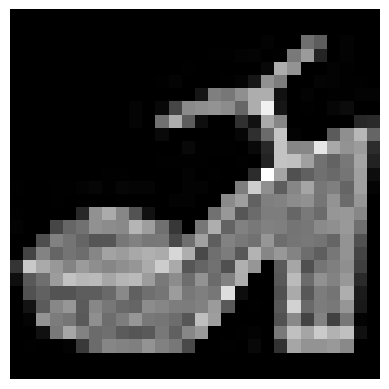

Label : Sandal


In [ ]:
# Function to show an image
def imshow(img):
  img = img / 2 + 0.5 # unnormlalize the image

  npimg = img.numpy()
  plt.imshow(np.squeeze(npimg), cmap='gray')
  plt.axis('off')
  plt.show()

# Get some random training images

dataiter = iter(trainloader)
images,labels = next(dataiter)

# show one image
imshow(images[0])
print('Label :',classes[labels[0]])

In [ ]:
# Define the Neural Network with Dropout

class NetwithDropout(nn.Module):
  def __init__(self):
    super(NetwithDropout, self).__init__()
    self.fc1 = nn.Linear(28 * 28, 256)  # First fully connected layer: input 784 (28x28 image) → 256 neurons
    self.dropout1 = nn.Dropout(0.5)   # Dropout layer with 50% drop probability to prevent overfitting
    self.relu1 = nn.ReLU()

    # Second fully connected layer: 256 → 128
    self.fc2 = nn.Linear(256, 128)
    self.dropout2 = nn.Dropout(0.5)
    self.relu2 = nn.ReLU()

    # Third fully connected layer: 128 → 64
    self.fc3 = nn.Linear(128, 64)
    self.dropout3 = nn.Dropout(0.5)
    self.relu3 = nn.ReLU()

    # Output layer: 64 → 10 (for 10 FashionMNIST classes)
    self.fc4 = nn.Linear(64, 10)
  def forward(self,x):
    # Flatten the 2D image to 1D vector: [batch_size, 1, 28, 28] → [batch_size, 784]
    x = x.view(-1, 28 * 28) # The '-1' lets PyTorch automatically infer the batch size based on the input
    # It keeps the first dimension dynamic and calculates it so that the total number of elements remains unchanged
    x = self.dropout1(self.relu1(self.fc1(x)))
    x = self.dropout2(self.relu2(self.fc2(x)))
    x = self.dropout3(self.relu3(self.fc3(x)))
    x = self.fc4(x)
    return x

net = NetwithDropout()



In [ ]:
# Choosing Loss Function and Optimizer

criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification tasks
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)
# Adam optimizer with L2 regularization (weight decay) to reduce overfitting

# Training Parameters and Variables

num_epochs = 10                    # Number of full passes through the training dataset
train_losses = []                 # List to store training loss after each epoch
val_losses = []                   # List to store validation loss after each epoch
best_val_loss = float('inf')     # Initialize best validation loss as infinity
patience = 3                     # Early stopping will trigger after 3 epochs with no improvement
trigger_times = 0                # Counter for epochs without improvement

# Training Loop with Early Stopping

for epoch in range(num_epochs):
    net.train()  # Set the model to training mode (activates dropout, batchnorm, etc.)
    running_train_loss = 0.0

    for inputs, labels in trainloader:
        optimizer.zero_grad()             # Clear previously accumulated gradients
        outputs = net(inputs)             # Forward pass: compute model predictions
        loss = criterion(outputs, labels) # Compute the loss between predictions and labels
        loss.backward()                   # Backward pass: compute gradients
        optimizer.step()                  # Update model parameters based on gradients

        running_train_loss += loss.item()  # Accumulate training loss

    train_loss = running_train_loss / len(trainloader)  # Average training loss per epoch
    train_losses.append(train_loss)                     # Store it for future visualization

    net.eval()  # Set the model to evaluation mode (disables dropout, batchnorm behavior)
    running_val_loss = 0.0
    with torch.no_grad():  # Disable gradient tracking for validation (saves memory and time)
        for inputs, labels in testloader:
            outputs = net(inputs)               # Forward pass on validation data
            loss = criterion(outputs, labels)   # Compute validation loss
            running_val_loss += loss.item()     # Accumulate validation loss

    val_loss = running_val_loss / len(testloader)  # Average validation loss per epoch
    val_losses.append(val_loss)                    # Store for tracking

    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss           # Update best validation loss
        trigger_times = 0                  # Reset early stopping counter
        torch.save(net.state_dict(), 'best_model.pth')  # Save the model's weights
    else:
        trigger_times += 1                # No improvement, increment counter
        if trigger_times >= patience:     # If no improvement for 'patience' epochs
            print('Early stopping!')      # Stop training early
            break



Epoch [1/10], Training Loss: 0.9097, Validation Loss: 0.6396
Epoch [2/10], Training Loss: 0.8237, Validation Loss: 0.5753
Epoch [3/10], Training Loss: 0.8048, Validation Loss: 0.6455
Epoch [4/10], Training Loss: 0.7929, Validation Loss: 0.5849
Epoch [5/10], Training Loss: 0.7956, Validation Loss: 0.5769
Early stopping!


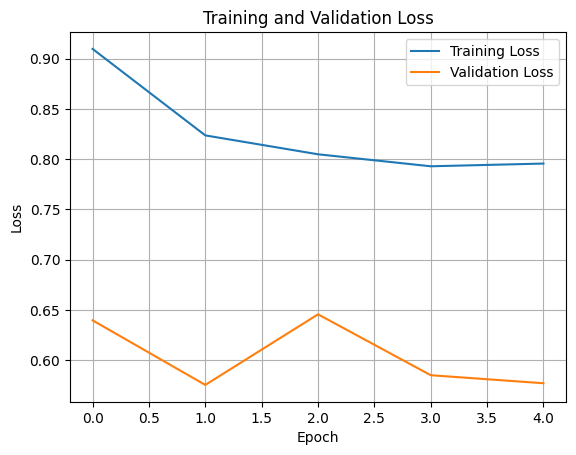

In [ ]:
# 6. Loading the Best Model

net.load_state_dict(torch.load('best_model.pth'))

# 7. Plotting the Losses

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def evaluate_network():
    net.eval()  # Set the model to evaluation mode (disables dropout, etc.)

    correct = 0     # Total correct predictions
    total = 0       # Total number of samples

    # For per-class accuracy tracking
    class_correct = [0] * 10  # Correct predictions per class (10 classes in FashionMNIST)
    class_total = [0] * 10    # Total samples per class

    with torch.no_grad():  # Disable gradient computation for efficiency
        for inputs, labels in testloader:
            outputs = net(inputs)                  # Forward pass
            _, predicted = torch.max(outputs, 1)   # Get class with highest score
            total += labels.size(0)                # Count total samples
            correct += (predicted == labels).sum().item()  # Count correct predictions

            # Track per-class accuracy
            c = (predicted == labels).squeeze()    # Boolean array of correct predictions
            for i in range(len(labels)):
                label = labels[i]                  # True label
                class_correct[label] += c[i].item()  # Increment correct count for that class
                class_total[label] += 1              # Increment total count for that class

    # Print overall test accuracy
    print(f'Overall Accuracy on the test set: {100 * correct / total:.2f}%\n')

    # Print per-class accuracy
    for i in range(10):
        if class_total[i] > 0:
            print(f'Accuracy of {classes[i]:>10s}: {100 * class_correct[i] / class_total[i]:.2f}%')
        else:
            print(f'Accuracy of {classes[i]:>10s}: N/A (no samples)')  # Just in case a class had 0 samples

# Call the evaluation function
evaluate_network()


Overall Accuracy on the test set: 79.66%

Accuracy of T-shirt/top: 88.00%
Accuracy of    Trouser: 94.90%
Accuracy of   Pullover: 71.50%
Accuracy of      Dress: 71.50%
Accuracy of       Coat: 73.90%
Accuracy of     Sandal: 90.00%
Accuracy of      Shirt: 40.60%
Accuracy of    Sneaker: 78.40%
Accuracy of        Bag: 92.70%
Accuracy of Ankle boot: 95.10%


## Create the scnario of the Exployding Gradient Decent & Implement Gradient clipping

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# 1. Data Import, Preparation, and Preprocessing

# Define transformations for the training and testing sets
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize the data to [-1, 1]
])

# Download and load the training data
trainset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=64,
    shuffle=True
)

# Download and load the testing data
testset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=64,
    shuffle=False
)

# Map numeric labels to class names
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 2. Defining the Neural Network

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(256, 128)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(128, 64)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(64, 10)  # Output layer

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.relu4(self.fc4(x))
        x = self.fc5(x)
        return x



Training without Gradient Clipping
Epoch [1/5], Loss: 2.2218
Epoch [2/5], Loss: 2.3061
Epoch [3/5], Loss: 2.3064
Epoch [4/5], Loss: 2.3064
Epoch [5/5], Loss: 2.3064
Finished Training without Clipping


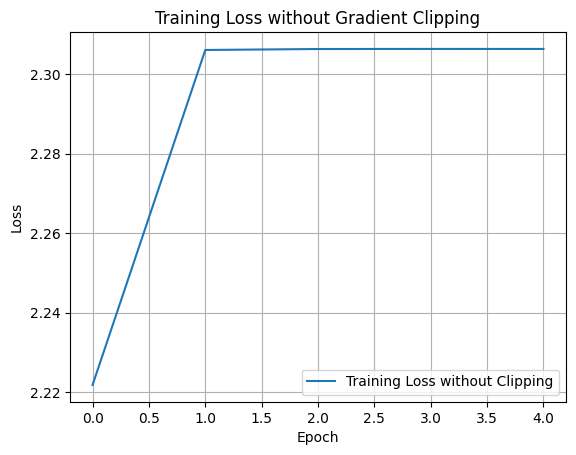

In [ ]:
# 3. Demonstrating the Exploding Gradient Problem

def train_without_clipping(net, optimizer, criterion, num_epochs=5):
    print("\nTraining without Gradient Clipping")
    net.train()

    train_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(trainloader)
        train_losses.append(epoch_loss)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    print('Finished Training without Clipping')
    return train_losses

# Initialize the network
net = SimpleNet()

# Define loss function and optimizer with a high learning rate
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1.0)  # High learning rate

# Train the network
losses_without_clipping = train_without_clipping(net, optimizer, criterion, num_epochs=5)

# Plot the training losses
plt.figure()
plt.plot(losses_without_clipping, label='Training Loss without Clipping')
plt.title('Training Loss without Gradient Clipping')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Training with Gradient Clipping
Epoch [1/5], Loss: 0.7893
Epoch [2/5], Loss: 0.5080
Epoch [3/5], Loss: 0.4509
Epoch [4/5], Loss: 0.4156
Epoch [5/5], Loss: 0.3957
Finished Training with Clipping


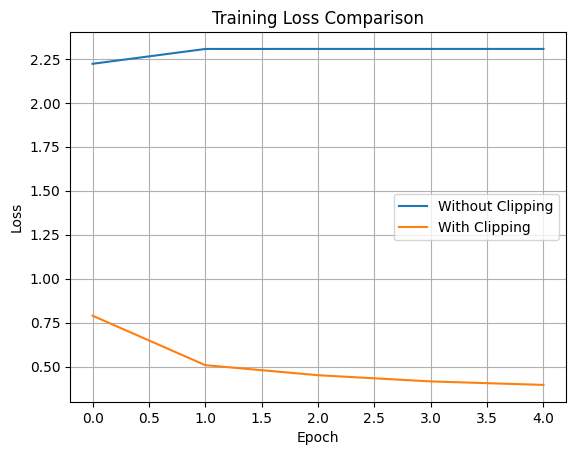

In [ ]:
# 5. Solving the Exploding Gradient Problem

def train_with_clipping(net, optimizer, criterion, clip_value=1.0, num_epochs=5):
    print("\nTraining with Gradient Clipping")
    net.train()

    train_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            # Apply gradient clipping
            torch.nn.utils.clip_grad_norm_(net.parameters(), clip_value)
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(trainloader)
        train_losses.append(epoch_loss)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    print('Finished Training with Clipping')
    return train_losses

# Re-initialize the network
net_clipped = SimpleNet()

# Define loss function and optimizer with the same high learning rate
optimizer_clipped = optim.SGD(net_clipped.parameters(), lr=1.0)  # High learning rate

# Train the network with gradient clipping
losses_with_clipping = train_with_clipping(net_clipped, optimizer_clipped, criterion, clip_value=1.0, num_epochs=5)

# Plot the training losses
plt.figure()
plt.plot(losses_without_clipping, label='Without Clipping')
plt.plot(losses_with_clipping, label='With Clipping')
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:

# 7. Evaluating the Model Trained With Gradient Clipping

def evaluate_model(net):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy on the test set: {100 * correct / total:.2f}%')

# Evaluate the model trained without clipping
print("\nEvaluating model trained without gradient clipping (may fail due to NaNs):")
evaluate_model(net)

# Evaluate the model trained with clipping
print("\nEvaluating model trained with gradient clipping:")
evaluate_model(net_clipped)



Evaluating model trained without gradient clipping (may fail due to NaNs):
Accuracy on the test set: 10.00%

Evaluating model trained with gradient clipping:
Accuracy on the test set: 82.20%


### Experiments with the Adam Optimizer


In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# 1. Data Import, Preparation, and Preprocessing

# Define transformations for the training and testing sets
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize the data to [-1, 1]
])

# Download and load the training data
trainset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=64,
    shuffle=True
)

# Download and load the testing data
testset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=64,
    shuffle=False
)

# Map numeric labels to class names
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 2. Defining the Neural Network

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(256, 128)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(128, 64)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(64, 10)  # Output layer

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.relu4(self.fc4(x))
        x = self.fc5(x)
        return x



Training with Optimizer (Adam)
Epoch [1/5], Loss: 0.5323
Epoch [2/5], Loss: 0.3797
Epoch [3/5], Loss: 0.3416
Epoch [4/5], Loss: 0.3147
Epoch [5/5], Loss: 0.2965
Finished Training with Optimizer (Adam)


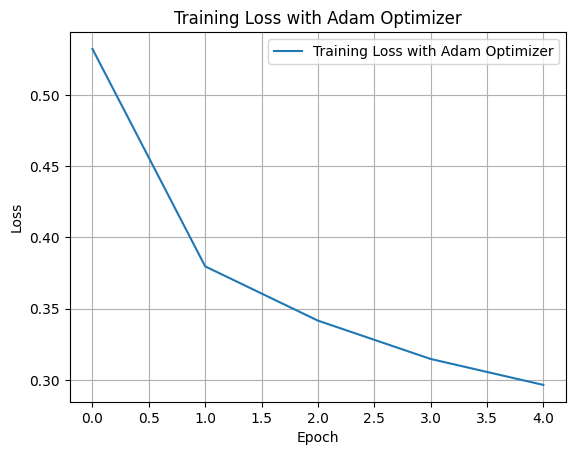

In [ ]:

# 3. Training Function Without Gradient Clipping (Using Adam Optimizer)

def train_with_optimizer(net, optimizer, criterion, num_epochs=5):
    print("\nTraining with Optimizer (Adam)")
    net.train()

    train_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(trainloader)
        train_losses.append(epoch_loss)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    print('Finished Training with Optimizer (Adam)')
    return train_losses

# Initialize the network
net = SimpleNet()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)  # Using Adam optimizer

# Train the network
losses_with_optimizer = train_with_optimizer(net, optimizer, criterion, num_epochs=5)

# Plot the training losses
plt.figure()
plt.plot(losses_with_optimizer, label='Training Loss with Adam Optimizer')
plt.title('Training Loss with Adam Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 4. Evaluating the Model Trained with Adam Optimizer

def evaluate_model(net):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy on the test set: {100 * correct / total:.2f}%')

# Evaluate the model
print("\nEvaluating model trained with Adam optimizer:")
evaluate_model(net)



Evaluating model trained with Adam optimizer:
Accuracy on the test set: 87.28%


## Implementation of L1 & L2 Regularization with optimizer


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# 1. Data Import, Preparation, and Preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# 2. Defining the Neural Network
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x


Training with L2 Regularization
Epoch [1/5], Loss: 0.6717
Epoch [2/5], Loss: 0.5369
Epoch [3/5], Loss: 0.4976
Epoch [4/5], Loss: 0.4821
Epoch [5/5], Loss: 0.4626


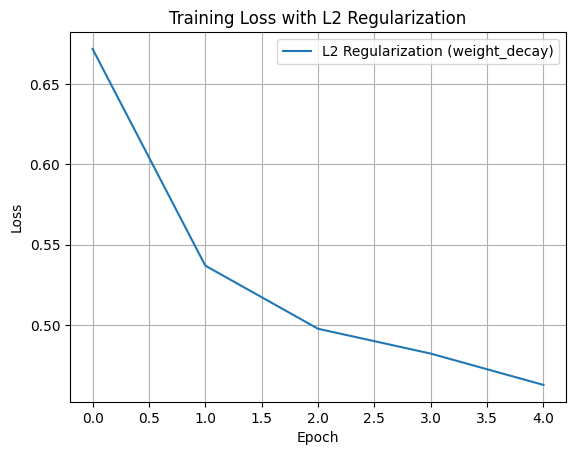

In [ ]:
# Initialize the network
net = SimpleNet()

# 3. Define the loss function (Cross-Entropy Loss) and optimizer
criterion = nn.CrossEntropyLoss()

# L2 Regularization using weight_decay in the optimizer
optimizer_l2 = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.01)  # L2 regularization

# Function for training with L2 regularization (via weight_decay)
def train_with_l2_regularization(net, optimizer, criterion, num_epochs=5):
    print("\nTraining with L2 Regularization")
    train_losses = []

    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            optimizer.zero_grad()         # Zero gradients
            outputs = net(inputs)         # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()               # Backpropagation
            optimizer.step()              # Update weights
            running_loss += loss.item()

        epoch_loss = running_loss / len(trainloader)
        train_losses.append(epoch_loss)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    return train_losses

# Train the model with L2 regularization
train_losses_l2 = train_with_l2_regularization(net, optimizer_l2, criterion, num_epochs=5)

# Plot the training loss for L2 regularization
plt.figure()
plt.plot(train_losses_l2, label='L2 Regularization (weight_decay)')
plt.title('Training Loss with L2 Regularization')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Training with L1 Regularization
Epoch [1/5], Loss: 4.9708
Epoch [2/5], Loss: 3.0177
Epoch [3/5], Loss: 3.0177
Epoch [4/5], Loss: 3.0177
Epoch [5/5], Loss: 3.0176


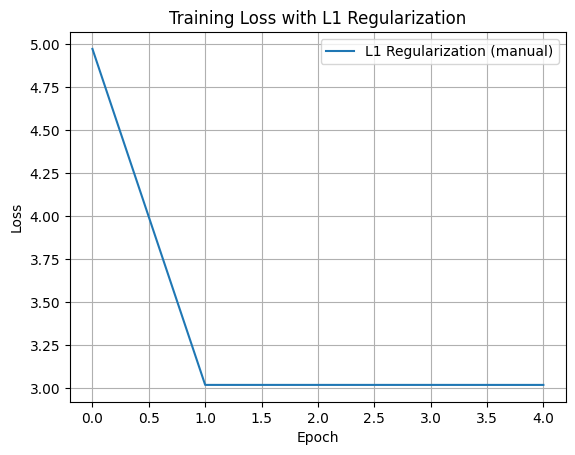

In [ ]:
# 4. L1 Regularization Implementation (Manually Adding L1 to Loss)
l1_lambda = 0.01  # The strength of L1 regularization

# Function for training with manual L1 regularization
def train_with_l1_regularization(net, optimizer, criterion, l1_lambda, num_epochs=5):
    print("\nTraining with L1 Regularization")
    train_losses = []

    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            optimizer.zero_grad()         # Zero gradients
            outputs = net(inputs)         # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

            # Manually add L1 regularization (sum of absolute values of weights)
            l1_norm = sum(p.abs().sum() for p in net.parameters())
            loss = loss + l1_lambda * l1_norm  # Add L1 penalty to the loss

            loss.backward()               # Backpropagation
            optimizer.step()              # Update weights
            running_loss += loss.item()

        epoch_loss = running_loss / len(trainloader)
        train_losses.append(epoch_loss)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    return train_losses

# Reinitialize the network for L1 training
net_l1 = SimpleNet()

# Define the optimizer without weight_decay for L1 (since we'll add L1 manually)
optimizer_l1 = optim.Adam(net_l1.parameters(), lr=0.001)

# Train the model with L1 regularization
train_losses_l1 = train_with_l1_regularization(net_l1, optimizer_l1, criterion, l1_lambda, num_epochs=5)

# Plot the training loss for L1 regularization
plt.figure()
plt.plot(train_losses_l1, label='L1 Regularization (manual)')
plt.title('Training Loss with L1 Regularization')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# 5. Model Evaluation
def evaluate_model(net, testloader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy: {100 * correct / total:.2f}%')

# Evaluate the model trained with L2 regularization
print("\nEvaluating model trained with L2 regularization:")
evaluate_model(net, testloader)

# Evaluate the model trained with L1 regularization
print("\nEvaluating model trained with L1 regularization:")
evaluate_model(net_l1, testloader)


Evaluating model trained with L2 regularization:
Accuracy: 82.60%

Evaluating model trained with L1 regularization:
Accuracy: 10.00%


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


# 1. Data Import , Preparation , and Preprocessing

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

trainset = torchvision.datasets.FashionMNIST(
    root = './data',
    train=True,
    download=True,
    transform = transform

)


100%|██████████| 26.4M/26.4M [00:01<00:00, 16.5MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 300kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.50MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 7.97MB/s]


In [5]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [6]:
testset = torchvision.datasets.FashionMNIST(
    root = './data',
    train=False,
    download = True,
    transform = transform

)

testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)


In [21]:
# 2. Defining the Neural Network
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# Initialize the network
net = SimpleNet()

# 3. Define the loss function (Cross-Entropy Loss)
criterion = nn.CrossEntropyLoss()

# Dummy input and output (batch of 64 samples)
inputs = torch.randn(64, 28 * 28)  # Example input (flattened images)
labels = torch.randint(0, 10, (64,))  # Example output (random labels)


In [24]:
# 4. Optimizer Functions and Training Steps

def train_model_with_optimizer(optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs_batch, labels in trainloader:  # Changed 'inputs' to 'inputs_batch'
            optimizer.zero_grad()         # Zero gradients
            outputs = net(inputs_batch)         # Pass 'inputs_batch' to the network
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()               # Backpropagation
            optimizer.step()              # Update weights
            running_loss += loss.item()
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}")

# Define all optimizers
optimizers = {
    "SGD": optim.SGD(net.parameters(), lr=0.01, momentum=0.9),
    "Adam": optim.Adam(net.parameters(), lr=0.001),
    "RMSprop": optim.RMSprop(net.parameters(), lr=0.001, alpha=0.99),
    "Adagrad": optim.Adagrad(net.parameters(), lr=0.01),
    "Adadelta": optim.Adadelta(net.parameters(), rho=0.9),
    "AdamW": optim.AdamW(net.parameters(), lr=0.001, weight_decay=0.01),
    "NAG": optim.SGD(net.parameters(), lr=0.01, momentum=0.9, nesterov=True),
    "Adamax": optim.Adamax(net.parameters(), lr=0.002),
}



In [25]:
# Train with each optimizer
for opt_name, optimizer in optimizers.items():
    print(f"\nTraining with {opt_name} optimizer")

    # Re-initialize the network and optimizer for each test
    net = SimpleNet()  # Re-initialize the model to avoid weight carryover
    optimizer = optimizers[opt_name]

    train_model_with_optimizer(optimizer, num_epochs=5)


Training with SGD optimizer
Epoch [1/5], Loss: 2.3057
Epoch [2/5], Loss: 2.3056
Epoch [3/5], Loss: 2.3057
Epoch [4/5], Loss: 2.3056
Epoch [5/5], Loss: 2.3056

Training with Adam optimizer
Epoch [1/5], Loss: 2.3046
Epoch [2/5], Loss: 2.3046
Epoch [3/5], Loss: 2.3046
Epoch [4/5], Loss: 2.3046
Epoch [5/5], Loss: 2.3046

Training with RMSprop optimizer
Epoch [1/5], Loss: 2.3078
Epoch [2/5], Loss: 2.3078
Epoch [3/5], Loss: 2.3078
Epoch [4/5], Loss: 2.3078
Epoch [5/5], Loss: 2.3078

Training with Adagrad optimizer
Epoch [1/5], Loss: 2.3056
Epoch [2/5], Loss: 2.3056
Epoch [3/5], Loss: 2.3056
Epoch [4/5], Loss: 2.3056
Epoch [5/5], Loss: 2.3056

Training with Adadelta optimizer
Epoch [1/5], Loss: 2.3034
Epoch [2/5], Loss: 2.3034
Epoch [3/5], Loss: 2.3034
Epoch [4/5], Loss: 2.3034
Epoch [5/5], Loss: 2.3034

Training with AdamW optimizer
Epoch [1/5], Loss: 2.3024
Epoch [2/5], Loss: 2.3024
Epoch [3/5], Loss: 2.3024
Epoch [4/5], Loss: 2.3024
Epoch [5/5], Loss: 2.3024

Training with NAG optimizer
E

In [26]:
# 5. Model Evaluation Function
def evaluate_model(net, testloader):
    net.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, labels in testloader:
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy: {100 * correct / total:.2f}%')

# Evaluate the model trained with the last optimizer
print("\nEvaluating the model with the last optimizer")
evaluate_model(net, testloader)


Evaluating the model with the last optimizer
Accuracy: 10.00%
